### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Load Dataset

In [ ]:
df_raw = pd.read_csv('../data/gold_price_data.csv')

In [ ]:
print("=== BASIC SHAPE & COLUMNS ===")
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())

###  Data Dictionary

| Column         | Description                                                                        |
| -------------- | ---------------------------------------------------------------------------------- |
| **date**       | วันที่ของข้อมูล                                                                    |
| **open**       | ราคาทองคำตอนเปิดตลาด                                                               |
| **high**       | ราคาสูงสุดของวันนั้น                                                               |
| **low**        | ราคาต่ำสุดของวันนั้น                                                               |
| **close**      | ราคาปิดตลาด (ปรับสำหรับ stock split แล้ว)                                          |
| **adj\_close** | ราคาปิดตลาดที่ปรับด้วย stock splits และ dividend distributions ตามมาตรฐาน **CRSP** |
| **volume**     | ปริมาณการซื้อขาย (จำนวนหุ้นที่ถูกซื้อขายในวันนั้น)                                 |

### Summary

In [ ]:
print(df_raw.dtypes)

In [ ]:
print("\n=== NULL COUNTS (per column) ===")
print(df_raw.isna().sum())

In [ ]:
summary = {
    "rows": len(df_raw),
    "date_min": pd.to_datetime(df_raw['date']).min().date().isoformat(),
    "date_max": pd.to_datetime(df_raw['date']).max().date().isoformat(),
    "close_min": float(df_raw['close'].min()),
    "close_max": float(df_raw['close'].max()),
    "adj_close_min": float(df_raw['adj_close'].min()),
    "adj_close_max": float(df_raw['adj_close'].max())
}

summary


### Clean & Index


In [ ]:

# ทำสำเนา dataset
df = df_raw.copy()

# 1) แปลงคอลัมน์ date เป็น datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2) ลบแถวที่ date ไม่สามารถแปลงได้
df = df.dropna(subset=['date'])

# 3) เรียงข้อมูลตาม date
df = df.sort_values('date').reset_index(drop=True)

# 4) ตั้ง date เป็น index
df = df.set_index('date')

# 5) กันวันที่ซ้ำ — เก็บแถวแรกไว้
df = df[~df.index.duplicated(keep='first')]

# 6) Summary เบื้องต้น
summary = {
    "rows": len(df),
    "date_min": df.index.min().date().isoformat(),
    "date_max": df.index.max().date().isoformat(),
    "close_min": float(df['close'].min()),
    "close_max": float(df['close'].max()),
    "adj_close_min": float(df['adj_close'].min()),
    "adj_close_max": float(df['adj_close'].max())
}
summary


### Visualization: Moving Average

#### Technical Indicators

Technical Indicators เป็นเครื่องมือวิเคราะห์ทางเทคนิคที่นิยมใช้ในตลาดการเงิน
ช่วยเสริมการมองเห็นแนวโน้ม (trend), ความแรง (momentum) และความผันผวน (volatility)

---

####  Moving Average (MA)

Moving Average (MA) คือ การคำนวณค่าเฉลี่ยของราคาย้อนหลัง *N วัน* แล้วเลื่อน (rolling) ไปเรื่อย ๆ
เพื่อช่วย **ลดความผันผวนระยะสั้น (noise)** และแสดง **แนวโน้ม (trend)** ของราคาได้ชัดเจนขึ้น

---

ประเภทของ MA ที่ใช้บ่อย

* **MA50** → ค่าเฉลี่ยย้อนหลัง 50 วัน

  * ใช้ดูแนวโน้ม ระยะสั้นถึงกลาง
* **MA200** → ค่าเฉลี่ยย้อนหลัง 200 วัน

  * ใช้ดูแนวโน้ม ระยะยาว

---

การตีความ

* ถ้า MA50 > MA200 → แนวโน้มขาขึ้น (Bullish Trend)
* ถ้า MA50 < MA200 → แนวโน้มขาลง (Bearish Trend)
* จุดที่เส้น MA50 ตัดขึ้นเหนือ MA200 → เรียกว่า Golden Cross (สัญญาณเชิงบวก)
* จุดที่เส้น MA50 ตัดลงใต้ MA200 → เรียกว่า Death Cross (สัญญาณเชิงลบ)

---



In [ ]:
plt.figure(figsize=(14, 7))

# Plot ราคาปิดที่ปรับแล้ว
df['adj_close'].plot(label='Adj Close', linewidth=1)

# Plot MA50 และ MA200
df['adj_close'].rolling(50).mean().plot(label='MA50', linewidth=1.2)
df['adj_close'].rolling(200).mean().plot(label='MA200', linewidth=1.2)

plt.title('Gold Price with 50-day & 200-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


---

RSI (Relative Strength Index)

เป็นตัวชี้วัด โมเมนตัม (momentum) ของราคา
คำนวณจากการเปรียบเทียบ “การขึ้น” กับ “การลง” ของราคาย้อนหลัง (เช่น 14 วัน)
ค่าอยู่ในช่วง 0 – 100
- RSI > 70 → ตลาดอยู่ในสภาวะ Overbought (ราคาขึ้นแรงเกินไป อาจมีโอกาสปรับฐานลง)
- RSI < 30 → ตลาดอยู่ในสภาวะ Oversold (ราคาลงแรงเกินไป อาจมีโอกาสเด้งกลับขึ้น)



In [ ]:
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Wilder’s smoothing ด้วย ewm(alpha=1/period)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_14 = compute_rsi(df['adj_close'], period=14)

plt.figure(figsize=(12, 5))
rsi_14.plot()
plt.title('RSI (14)')
plt.xlabel('Date'); plt.ylabel('RSI')
plt.axhline(70, linestyle='--')
plt.axhline(30, linestyle='--')
plt.tight_layout(); plt.show()


#### Pivot Points 

แนวคิด : 
- ใช้ข้อมูล High / Low / Close ของรอบก่อนหน้า (เช่น วันก่อน, เดือนก่อน)
- สร้างค่าอ้างอิงชื่อว่า Pivot Point (PP)
- แล้วคำนวณแนวรับ (Support) และแนวต้าน (Resistance) เพิ่มจาก PP
- นิยมใช้เพราะ ง่ายและรวดเร็ว โดยเฉพาะในตลาดหุ้น/ฟิวเจอร์ส

---

#### สูตรคำนวณ
---
##### 1. **Pivot Point (PP)**

$$
PP = \frac{High + Low + Close}{3}
$$

เป็นค่า “จุดสมดุล” ระหว่างแรงซื้อและแรงขาย

---

##### 2. **แนวต้าน (Resistance)**

* **R1 (Resistance 1)**

$$
R1 = 2 \times PP - Low
$$

* **R2 (Resistance 2)**

$$
R2 = PP + (High - Low)
$$

---

##### 3. **แนวรับ (Support)**

* **S1 (Support 1)**

$$
S1 = 2 \times PP - High
$$

* **S2 (Support 2)**

$$
S2 = PP - (High - Low)
$$

---

##### การตีความ
* ถ้าราคาอยู่ **เหนือ PP** → มีแนวโน้มเป็น **ตลาดขาขึ้น** (bullish bias)
* ถ้าราคาอยู่ **ต่ำกว่า PP** → มีแนวโน้มเป็น **ตลาดขาลง** (bearish bias)
* **R1 / S1** = ระดับแนวต้านและแนวรับแรก → ใช้สำหรับ “จุดกลับตัว” ระยะสั้น
* **R2 / S2** = ระดับที่แรงกว่า → ถ้าราคาทะลุไปได้ อาจมีการ breakout ใหญ่

---

##### ตัวอย่าง (สมมติ)

ถ้าเดือนก่อนมีค่า:

* High = 210
* Low = 190
* Close = 200

จะได้ว่า:

* $PP = (210 + 190 + 200) / 3 = 200$
* $R1 = 2 \times 200 - 190 = 210$
* $S1 = 2 \times 200 - 210 = 190$
* $R2 = 200 + (210 - 190) = 220$
* $S2 = 200 - (210 - 190) = 180$

ดังนั้น **แนวรับ–แนวต้าน = 180, 190, 200, 210, 220**

In [ ]:
# Step 7B — Monthly Pivot Points (PP, S1/S2, R1/R2)
import pandas as pd
import matplotlib.pyplot as plt

# สรุป OHLC รายเดือน
m = df.resample('M').agg({'high':'max','low':'min','close':'last'})
PP = (m['high'] + m['low'] + m['close']) / 3
R1 = 2*PP - m['low']; S1 = 2*PP - m['high']
R2 = PP + (m['high'] - m['low']); S2 = PP - (m['high'] - m['low'])

# เลือก “เดือนล่าสุด” เพื่อลากเป็นระดับอ้างอิงปัจจุบัน
latest = m.index.max()
pp, r1, r2, s1, s2 = PP.loc[latest], R1.loc[latest], R2.loc[latest], S1.loc[latest], S2.loc[latest]

plt.figure(figsize=(14, 6))
df['adj_close'].plot(label='Adj Close', linewidth=1)

for level, name in [(r2,'R2'),(r1,'R1'),(pp,'PP'),(s1,'S1'),(s2,'S2')]:
    plt.axhline(level, linestyle='--', label=f'{name}: {level:.2f}')

plt.title('Adj Close with Monthly Pivot Levels (latest month)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
view = df.loc['2024':'2025']
plt.figure(figsize=(14, 6))
view['adj_close'].plot(label='Adj Close', linewidth=1)

for level, name in [(r2,'R2'),(r1,'R1'),(pp,'PP'),(s1,'S1'),(s2,'S2')]:
    plt.axhline(level, linestyle='--', label=f'{name}: {level:.2f}')

plt.title('Adj Close with Latest Monthly Pivot Levels (zoom 2024–2025)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


### Demo

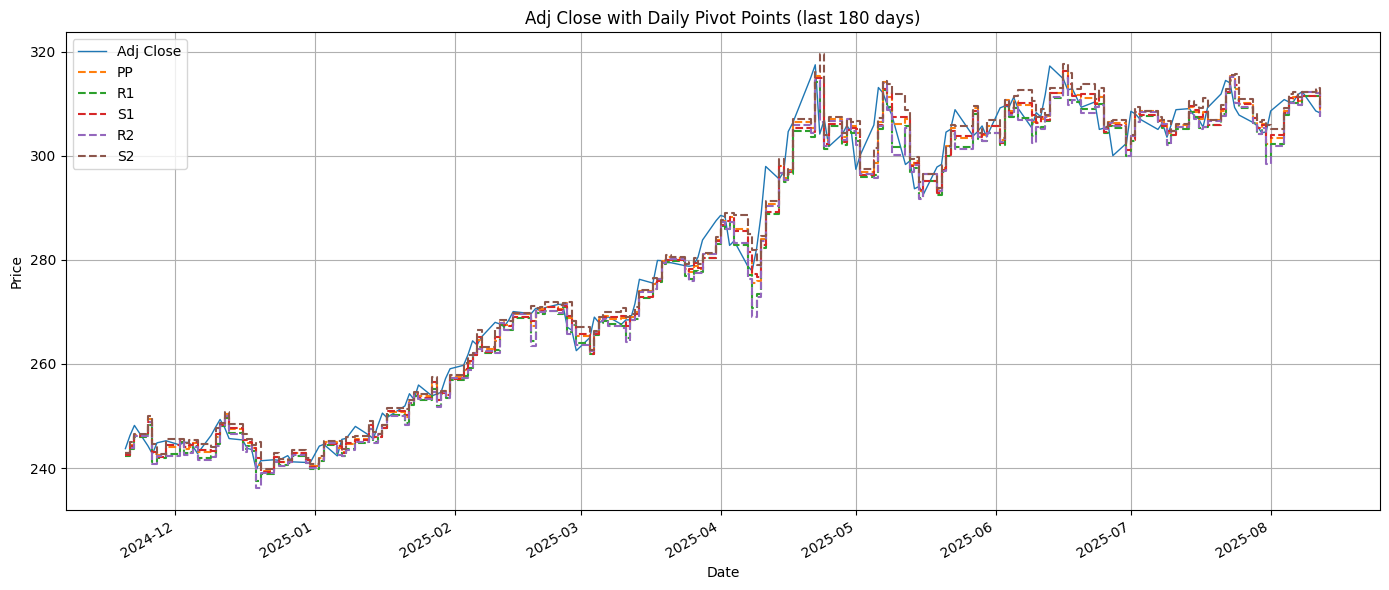

In [16]:
# Step 7 — Daily Pivot Points (Classic) using previous day's H/L/C

import pandas as pd
import matplotlib.pyplot as plt

# ใช้ค่าเมื่อวาน เพื่อหลีกเลี่ยง look-ahead bias
prev = df[['high','low','close']].shift(1).rename(
    columns={'high':'H_prev','low':'L_prev','close':'C_prev'}
)

PP = (prev['H_prev'] + prev['L_prev'] + prev['C_prev']) / 3
R1 = 2*PP - prev['L_prev']
S1 = 2*PP - prev['H_prev']
R2 = PP + (prev['H_prev'] - prev['L_prev'])
S2 = PP - (prev['H_prev'] - prev['L_prev'])

# รวมเป็นตารางเดียว เผื่ออยากตรวจสอบ/ใช้งานต่อ
pivots_daily = pd.DataFrame({'PP': PP, 'R1': R1, 'S1': S1, 'R2': R2, 'S2': S2})

# เลือกช่วงแสดงผล (เช่น 180 วันล่าสุด เพื่อให้เห็นชัด)
last_n = 180
view_price  = df['adj_close'].iloc[-last_n:]
view_levels = pivots_daily.iloc[-last_n:]

plt.figure(figsize=(14, 6))
view_price.plot(label='Adj Close', linewidth=1)

# วาดเส้นแบบ step-post เพื่อเห็นระดับ pivot เปลี่ยนทุกวัน
view_levels['PP'].plot(drawstyle='steps-post', linestyle='--', label='PP')
view_levels['R1'].plot(drawstyle='steps-post', linestyle='--', label='R1')
view_levels['S1'].plot(drawstyle='steps-post', linestyle='--', label='S1')
view_levels['R2'].plot(drawstyle='steps-post', linestyle='--', label='R2')
view_levels['S2'].plot(drawstyle='steps-post', linestyle='--', label='S2')

plt.title(f'Adj Close with Daily Pivot Points (last {last_n} days)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


In [ ]:
# Step 9 — Interactive GUI (ipywidgets)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import (
    VBox, HBox, Tab, Layout,
    ToggleButtons, IntSlider, Checkbox, SelectionSlider, Dropdown
)

plt.rcParams['figure.figsize'] = (14, 6)

# ---------- Helper functions ----------
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def daily_pivots(df: pd.DataFrame) -> pd.DataFrame:
    prev = df[['high','low','close']].shift(1).rename(
        columns={'high':'H_prev','low':'L_prev','close':'C_prev'}
    )
    PP = (prev['H_prev'] + prev['L_prev'] + prev['C_prev']) / 3
    R1 = 2*PP - prev['L_prev']
    S1 = 2*PP - prev['H_prev']
    R2 = PP + (prev['H_prev'] - prev['L_prev'])
    S2 = PP - (prev['H_prev'] - prev['L_prev'])
    return pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})

def monthly_pivots(df: pd.DataFrame) -> pd.DataFrame:
    m = df.resample('M').agg({'high':'max','low':'min','close':'last'})
    PP = (m['high'] + m['low'] + m['close']) / 3
    R1 = 2*PP - m['low']
    S1 = 2*PP - m['high']
    R2 = PP + (m['high'] - m['low'])
    S2 = PP - (m['high'] - m['low'])
    piv = pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})
    # ขยายเป็น daily step-line ด้วย ffill เพื่อวาดซ้อนกับราคาได้
    return piv.reindex(df.index, method='ffill')

# ---------- Widgets ----------
view_selector = ToggleButtons(
    options=[('MA', 'ma'), ('RSI', 'rsi'), ('Pivot', 'pivot')],
    value='ma',
    description='View:',
)

# MA controls
ma_short = IntSlider(value=50, min=5, max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

# RSI controls
rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

# Pivot controls
pivot_type = ToggleButtons(options=[('Daily','daily'), ('Monthly','monthly')], value='daily', description='Pivot:')
pivot_levels = Dropdown(
    options=[('PP,R1,S1', 'pp_r1_s1'), ('PP–R2–S2', 'pp_r2_s2')],
    value='pp_r1_s1',
    description='Levels:'
)

# General controls
last_n = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')

controls_row1 = HBox([view_selector, last_n])
controls_ma   = HBox([ma_short, ma_long, ma_show_cross])
controls_rsi  = HBox([rsi_period])
controls_piv  = HBox([pivot_type, pivot_levels])

ui = VBox([controls_row1, controls_ma, controls_rsi, controls_piv])

# ---------- Reactive plotting ----------
def update_plot(*args):
    plt.figure()
    data = df.iloc[-last_n.value:]

    if view_selector.value == 'ma':
        data['adj_close'].plot(label='Adj Close', linewidth=1)
        data['adj_close'].rolling(ma_short.value).mean().plot(label=f'MA{ma_short.value}', linewidth=1.2)
        data['adj_close'].rolling(ma_long.value).mean().plot(label=f'MA{ma_long.value}', linewidth=1.2)

        if ma_show_cross.value:
            fast = data['adj_close'].rolling(ma_short.value).mean()
            slow = data['adj_close'].rolling(ma_long.value).mean()
            cross_up = (fast > slow) & (fast.shift(1) <= slow.shift(1))
            cross_dn = (fast < slow) & (fast.shift(1) >= slow.shift(1))
            plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
            plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

        plt.title('Adj Close with Moving Averages')
        plt.xlabel('Date'); plt.ylabel('Price')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()
        return

    if view_selector.value == 'rsi':
        rsi = compute_rsi(data['adj_close'], rsi_period.value)
        rsi.plot()
        plt.title(f'RSI ({rsi_period.value})')
        plt.xlabel('Date'); plt.ylabel('RSI')
        plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
        plt.grid(True); plt.tight_layout()
        plt.show()
        return

    if view_selector.value == 'pivot':
        data['adj_close'].plot(label='Adj Close', linewidth=1)
        if pivot_type.value == 'daily':
            piv = daily_pivots(df).iloc[-last_n.value:]
        else:
            piv = monthly_pivots(df).iloc[-last_n.value:]

        # Show selected levels
        if pivot_levels.value == 'pp_r1_s1':
            for col in ['PP','R1','S1']:
                piv[col].plot(drawstyle='steps-post', linestyle='--', label=col)
        else:
            for col in ['PP','R1','S1','R2','S2']:
                piv[col].plot(drawstyle='steps-post', linestyle='--', label=col)

        plt.title(f'Adj Close with {pivot_type.value.capitalize()} Pivots')
        plt.xlabel('Date'); plt.ylabel('Price')
        plt.legend(); plt.grid(True); plt.tight_layout()
        plt.show()
        return

# initial draw
update_plot()

# make reactive
for w in [view_selector, last_n, ma_short, ma_long, ma_show_cross, rsi_period, pivot_type, pivot_levels]:
    w.observe(update_plot, names='value')

ui


In [17]:
from ipywidgets import Output, VBox, HBox, ToggleButtons, IntSlider, Checkbox, Dropdown
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# (สมมติว่ามี df และ compute_rsi, daily_pivots, monthly_pivots แล้วตามที่เราทำไว้ก่อนหน้า)

# ---------- Widgets (ใช้ชุดเดิมได้เลย) ----------
view_selector = ToggleButtons(options=[('MA','ma'),('RSI','rsi'),('Pivot','pivot')], value='ma', description='View:')
last_n = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')

ma_short = IntSlider(value=50, min=5, max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

pivot_type = ToggleButtons(options=[('Daily','daily'),('Monthly','monthly')], value='daily', description='Pivot:')
pivot_levels = Dropdown(options=[('PP,R1,S1','pp_r1_s1'),('PP–R2–S2','pp_r2_s2')], value='pp_r1_s1', description='Levels:')

controls = VBox([
    HBox([view_selector, last_n]),
    HBox([ma_short, ma_long, ma_show_cross]),
    HBox([rsi_period]),
    HBox([pivot_type, pivot_levels]),
])

# ---------- Output area (จุดสำคัญ) ----------
out = Output()

def update_plot(*_):
    with out:
        clear_output(wait=True)          # <-- เขียนทับกราฟเดิม
        data = df.iloc[-last_n.value:]

        if view_selector.value == 'ma':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)
            data['adj_close'].rolling(ma_short.value).mean().plot(label=f'MA{ma_short.value}', linewidth=1.2)
            data['adj_close'].rolling(ma_long.value).mean().plot(label=f'MA{ma_long.value}', linewidth=1.2)

            if ma_show_cross.value:
                fast = data['adj_close'].rolling(ma_short.value).mean()
                slow = data['adj_close'].rolling(ma_long.value).mean()
                cross_up = (fast > slow) & (fast.shift(1) <= slow.shift(1))
                cross_dn = (fast < slow) & (fast.shift(1) >= slow.shift(1))
                plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
                plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

            plt.title('Adj Close with Moving Averages')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()
            return

        if view_selector.value == 'rsi':
            rsi = compute_rsi(data['adj_close'], rsi_period.value)
            plt.figure(figsize=(14,4))
            rsi.plot()
            plt.title(f'RSI ({rsi_period.value})')
            plt.xlabel('Date'); plt.ylabel('RSI')
            plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
            plt.grid(True); plt.tight_layout()
            plt.show()
            return

        if view_selector.value == 'pivot':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)
            piv = daily_pivots(df).iloc[-last_n.value:] if pivot_type.value=='daily' else monthly_pivots(df).iloc[-last_n.value:]
            cols = ['PP','R1','S1'] if pivot_levels.value=='pp_r1_s1' else ['PP','R1','S1','R2','S2']
            for c in cols:
                piv[c].plot(drawstyle='steps-post', linestyle='--', label=c)
            plt.title(f'Adj Close with {pivot_type.value.capitalize()} Pivots')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.grid(True); plt.tight_layout()
            plt.show()
            return

# ผูกอีเวนต์ให้รีเฟรชกราฟ “ทับ” เดิม
for w in [view_selector, last_n, ma_short, ma_long, ma_show_cross, rsi_period, pivot_type, pivot_levels]:
    w.observe(update_plot, names='value')

# วาดครั้งแรก + แสดง UI
update_plot()
display(controls, out)


Output()

In [ ]:
# ---------- (1) เพิ่มตัวเลือก Candles ใน view_selector ----------
from ipywidgets import Output, VBox, HBox, ToggleButtons, IntSlider, Checkbox, Dropdown
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

view_selector = ToggleButtons(
    options=[('MA','ma'), ('RSI','rsi'), ('Pivot','pivot'), ('Candles','candles')],
    value='ma',
    description='View:',
)

# ---------- (2) เพิ่มตัวเลือก overlay MA บนกราฟแท่งเทียน ----------
overlay_ma_on_candle = Checkbox(value=True, description='Overlay MA on Candles')

# Widgets อื่น ๆ ใช้เหมือนเดิม
last_n = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')
ma_short = IntSlider(value=50, min=5, max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

pivot_type = ToggleButtons(options=[('Daily','daily'),('Monthly','monthly')], value='daily', description='Pivot:')
pivot_levels = Dropdown(options=[('PP,R1,S1','pp_r1_s1'),('PP–R2–S2','pp_r2_s2')], value='pp_r1_s1', description='Levels:')

controls = VBox([
    HBox([view_selector, last_n]),
    HBox([ma_short, ma_long, ma_show_cross, overlay_ma_on_candle]),
    HBox([rsi_period]),
    HBox([pivot_type, pivot_levels]),
])

# ---------- (3) ฟังก์ชันวาดแท่งเทียน (ไม่ใช้ mplfinance) ----------
def plot_candles(data: pd.DataFrame, ax=None, width=0.6):
    """
    data ต้องมีคอลัมน์: open, high, low, close และ index เป็น datetime
    """
    if ax is None:
        ax = plt.gca()
    x = mdates.date2num(data.index.to_pydatetime())

    for i, (xi, o, h, l, c) in enumerate(zip(x, data['open'], data['high'], data['low'], data['close'])):
        # เส้นไส้เทียน
        ax.vlines(xi, l, h, linewidth=1)

        # ตัวแท่ง
        if c >= o:  # ขึ้น (เขียว)
            lower = o
            height = c - o
            face = 'green'
            edge = 'green'
        else:       # ลง (แดง)
            lower = c
            height = o - c
            face = 'red'
            edge = 'red'

        # แท่งที่ราคาไม่เปลี่ยน (doji)
        if height == 0:
            height = 0.001

        rect = plt.Rectangle((xi - width/2, lower), width, height, facecolor=face, edgecolor=edge, linewidth=1)
        ax.add_patch(rect)

    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    ax.set_xlim(x.min()-1, x.max()+1)
    ax.grid(True)
    return ax

# ---------- (4) Output + update_plot (เขียนทับกราฟเดิม) ----------
out = Output()

def update_plot(*_):
    with out:
        clear_output(wait=True)
        data = df.iloc[-last_n.value:]

        if view_selector.value == 'ma':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)
            data['adj_close'].rolling(ma_short.value).mean().plot(label=f'MA{ma_short.value}', linewidth=1.2)
            data['adj_close'].rolling(ma_long.value).mean().plot(label=f'MA{ma_long.value}', linewidth=1.2)

            if ma_show_cross.value:
                fast = data['adj_close'].rolling(ma_short.value).mean()
                slow = data['adj_close'].rolling(ma_long.value).mean()
                cross_up = (fast > slow) & (fast.shift(1) <= slow.shift(1))
                cross_dn = (fast < slow) & (fast.shift(1) >= slow.shift(1))
                plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
                plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

            plt.title('Adj Close with Moving Averages')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'rsi':
            rsi = compute_rsi(data['adj_close'], rsi_period.value)
            plt.figure(figsize=(14,4))
            rsi.plot()
            plt.title(f'RSI ({rsi_period.value})')
            plt.xlabel('Date'); plt.ylabel('RSI')
            plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
            plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'pivot':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)
            piv = daily_pivots(df).iloc[-last_n.value:] if pivot_type.value=='daily' else monthly_pivots(df).iloc[-last_n.value:]
            cols = ['PP','R1','S1'] if pivot_levels.value=='pp_r1_s1' else ['PP','R1','S1','R2','S2']
            for c in cols:
                piv[c].plot(drawstyle='steps-post', linestyle='--', label=c)
            plt.title(f'Adj Close with {pivot_type.value.capitalize()} Pivots')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'candles':
            fig, ax = plt.subplots(figsize=(14,6))
            plot_candles(data, ax=ax, width=0.6)
            ax.set_title('Candlestick (OHLC)')
            ax.set_xlabel('Date'); ax.set_ylabel('Price')

            if overlay_ma_on_candle.value:
                data['adj_close'].rolling(ma_short.value).mean().plot(ax=ax, linewidth=1.2, label=f'MA{ma_short.value}')
                data['adj_close'].rolling(ma_long.value).mean().plot(ax=ax, linewidth=1.2, label=f'MA{ma_long.value}')
                ax.legend()

            plt.tight_layout(); plt.show()
            return

# ผูก event
for w in [view_selector, last_n, ma_short, ma_long, ma_show_cross, overlay_ma_on_candle,
          rsi_period, pivot_type, pivot_levels]:
    w.observe(update_plot, names='value')

# แสดง UI + วาดครั้งแรก
update_plot()
display(controls, out)


Output()

In [21]:
# ===========================
# Interactive GUI (All-in-one)
# ===========================
from ipywidgets import Output, VBox, HBox, ToggleButtons, IntSlider, Checkbox, Dropdown, Layout
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import numpy as np
import pandas as pd

# ---------- Validate df ----------
required_cols = {'open','high','low','close','adj_close'}
assert 'df' in globals(), "ต้องมีตัวแปร df (DataFrame) ที่เตรียมจาก Step 4 แล้ว"
assert required_cols.issubset(df.columns), f"df ต้องมีคอลัมน์ {required_cols}"
assert pd.api.types.is_datetime64_any_dtype(df.index), "df.index ต้องเป็น datetime"

# ---------- Helpers ----------
def compute_rsi(series: pd.Series, period: int = 14) -> pd.Series:
    delta = series.diff()
    gain  = delta.clip(lower=0)
    loss  = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def daily_pivots(df: pd.DataFrame) -> pd.DataFrame:
    prev = df[['high','low','close']].shift(1).rename(
        columns={'high':'H_prev','low':'L_prev','close':'C_prev'}
    )
    PP = (prev['H_prev'] + prev['L_prev'] + prev['C_prev']) / 3
    R1 = 2*PP - prev['L_prev']
    S1 = 2*PP - prev['H_prev']
    R2 = PP + (prev['H_prev'] - prev['L_prev'])
    S2 = PP - (prev['H_prev'] - prev['L_prev'])
    return pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})

def monthly_pivots(df: pd.DataFrame) -> pd.DataFrame:
    # สรุป OHLC รายเดือน (ใช้ 'ME' แทน 'M' เพื่อเลี่ยง FutureWarning)
    m = df.resample('ME').agg({'high':'max','low':'min','close':'last'}).dropna(how='any')
    if m.empty:
        return pd.DataFrame(index=df.index, columns=['PP','R1','S1','R2','S2'])
    PP = (m['high'] + m['low'] + m['close']) / 3
    R1 = 2*PP - m['low'];  S1 = 2*PP - m['high']
    R2 = PP + (m['high'] - m['low']);  S2 = PP - (m['high'] - m['low'])
    piv_m = pd.DataFrame({'PP':PP,'R1':R1,'S1':S1,'R2':R2,'S2':S2})
    # กระจายเป็นรายวันแบบ step แล้ว align กับวันทำการจริง
    piv_daily   = piv_m.reindex(df.resample('D').asfreq().index, method='ffill')
    piv_aligned = piv_daily.reindex(df.index, method='ffill')
    return piv_aligned

def plot_candles(data: pd.DataFrame, ax=None, width=None):
    """
    วาดแท่งเทียนจากคอลัมน์ open, high, low, close
    ปรับความกว้างแท่งตามช่องว่างวันที่ (dynamic width)
    """
    if ax is None:
        ax = plt.gca()
    x = mdates.date2num(data.index.to_pydatetime())
    if width is None:
        if len(x) > 1:
            spacing = np.diff(x)
            width = np.median(spacing) * 0.8
        else:
            width = 0.6

    for xi, o, h, l, c in zip(x, data['open'], data['high'], data['low'], data['close']):
        ax.vlines(xi, l, h, linewidth=1)
        up = c >= o
        lower  = o if up else c
        height = (c - o) if up else (o - c)
        if height == 0:
            height = 1e-6  # ป้องกัน doji สูง 0
        color = 'green' if up else 'red'
        rect = patches.Rectangle((xi - width/2, lower), width, height, facecolor=color, edgecolor=color, linewidth=1)
        ax.add_patch(rect)

    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    ax.set_xlim(x.min()-width, x.max()+width)
    ax.grid(True)
    return ax

# ---------- Widgets ----------
view_selector = ToggleButtons(
    options=[('MA','ma'), ('RSI','rsi'), ('Pivot','pivot'), ('Candles','candles')],
    value='ma',
    description='View:',
)

last_n = IntSlider(value=180, min=60, max=1000, step=10, description='Last N days')

# MA
ma_short = IntSlider(value=50,  min=5,  max=150, step=1, description='MA short')
ma_long  = IntSlider(value=200, min=20, max=300, step=5, description='MA long')
ma_show_cross = Checkbox(value=False, description='Show cross markers')

# RSI
rsi_period = IntSlider(value=14, min=5, max=50, step=1, description='RSI period')

# Pivot
pivot_type = ToggleButtons(options=[('Daily','daily'), ('Monthly','monthly')], value='daily', description='Pivot:')
pivot_style = ToggleButtons(options=[('Line','line'), ('Candles','candles')], value='line', description='Pivot style:')
pivot_levels = Dropdown(options=[('PP,R1,S1','pp_r1_s1'), ('PP–R2–S2','pp_r2_s2')], value='pp_r1_s1', description='Levels:')

# Candles overlay
overlay_ma_on_candle = Checkbox(value=True, description='Overlay MA on Candles')

# Layout groups
def set_display(widget, show: bool):
    widget.layout.display = '' if show else 'none'

row_top  = HBox([view_selector, last_n])
row_ma   = HBox([ma_short, ma_long, ma_show_cross])
row_rsi  = HBox([rsi_period])
row_piv  = HBox([pivot_type, pivot_style, pivot_levels])
row_cndl = HBox([overlay_ma_on_candle])

controls = VBox([row_top, row_ma, row_rsi, row_piv, row_cndl])

def update_visibility(view_value: str):
    # MA controls: ใช้ในโหมด MA และซ้อนบน Candles/Pivot-Candles ได้
    set_display(row_ma,   view_value in ('ma','candles') or (view_value=='pivot' and pivot_style.value=='candles'))
    set_display(row_rsi,  view_value == 'rsi')
    set_display(row_piv,  view_value == 'pivot')
    is_candle_context = (view_value == 'candles') or (view_value == 'pivot' and pivot_style.value == 'candles')
    set_display(row_cndl, is_candle_context)

# ---------- Output ----------
out = Output()

# ---------- Plotting ----------
def update_plot(*_):
    with out:
        clear_output(wait=True)
        data = df.iloc[-last_n.value:].copy()

        if view_selector.value == 'ma':
            plt.figure(figsize=(14,6))
            data['adj_close'].plot(label='Adj Close', linewidth=1)

            fast = data['adj_close'].rolling(ma_short.value).mean()
            slow = data['adj_close'].rolling(ma_long.value).mean()
            fast.plot(label=f'MA{ma_short.value}', linewidth=1.2)
            slow.plot(label=f'MA{ma_long.value}',  linewidth=1.2)

            if ma_show_cross.value:
                mask = fast.notna() & slow.notna()
                cross_up = mask & (fast > slow) & (fast.shift(1) <= slow.shift(1))
                cross_dn = mask & (fast < slow) & (fast.shift(1) >= slow.shift(1))
                plt.scatter(data.index[cross_up], data['adj_close'][cross_up], marker='^')
                plt.scatter(data.index[cross_dn], data['adj_close'][cross_dn], marker='v')

            plt.title('Adj Close with Moving Averages')
            plt.xlabel('Date'); plt.ylabel('Price')
            plt.legend(); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'rsi':
            plt.figure(figsize=(14,4))
            rsi = compute_rsi(data['adj_close'], rsi_period.value)
            rsi.plot()
            plt.title(f'RSI ({rsi_period.value})')
            plt.xlabel('Date'); plt.ylabel('RSI')
            plt.axhline(70, linestyle='--'); plt.axhline(30, linestyle='--')
            plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'pivot':
            fig, ax = plt.subplots(figsize=(14,6))

            # พื้นหลัง: line หรือ candles
            if pivot_style.value == 'line':
                data['adj_close'].plot(ax=ax, label='Adj Close', linewidth=1)
            else:
                plot_candles(data, ax=ax, width=None)
                if overlay_ma_on_candle.value:
                    fast = data['adj_close'].rolling(ma_short.value).mean()
                    slow = data['adj_close'].rolling(ma_long.value).mean()
                    fast.plot(ax=ax, linewidth=1.2, label=f'MA{ma_short.value}')
                    slow.plot(ax=ax, linewidth=1.2, label=f'MA{ma_long.value}')

            # คำนวณ Pivot (align กับช่วงที่แสดง)
            piv = daily_pivots(df).reindex(data.index) if pivot_type.value == 'daily' else monthly_pivots(df).reindex(data.index)

            cols = ['PP','R1','S1'] if pivot_levels.value == 'pp_r1_s1' else ['PP','R1','S1','R2','S2']
            for c in cols:
                piv[c].plot(ax=ax, drawstyle='steps-post', linestyle='--', label=c)

            ax.set_title(f"Pivot ({pivot_type.value.capitalize()}) — style: {pivot_style.value.capitalize()}")
            ax.set_xlabel('Date'); ax.set_ylabel('Price')
            ax.legend(); plt.tight_layout(); plt.show()
            return

        if view_selector.value == 'candles':
            fig, ax = plt.subplots(figsize=(14,6))
            plot_candles(data, ax=ax, width=None)
            ax.set_title('Candlestick (OHLC)')
            ax.set_xlabel('Date'); ax.set_ylabel('Price')

            if overlay_ma_on_candle.value:
                fast = data['adj_close'].rolling(ma_short.value).mean()
                slow = data['adj_close'].rolling(ma_long.value).mean()
                fast.plot(ax=ax, linewidth=1.2, label=f'MA{ma_short.value}')
                slow.plot(ax=ax, linewidth=1.2, label=f'MA{ma_long.value}')
                ax.legend()

            plt.tight_layout(); plt.show()
            return

def on_view_change(change):
    if change['name'] == 'value':
        update_visibility(change['new'])
        update_plot()

# ---------- Wire events ----------
for w in [last_n, ma_short, ma_long, ma_show_cross, rsi_period, pivot_type, pivot_style, pivot_levels, overlay_ma_on_candle]:
    w.observe(update_plot, names='value')
view_selector.observe(on_view_change, names='value')

# ---------- Initial render ----------
update_visibility(view_selector.value)
update_plot()
display(controls, out)


Output()